In [637]:
%matplotlib notebook
import numpy as np
import operator
import scipy
import scipy.ndimage
import matplotlib.patches
from scipy.spatial import distance
import photutils
from photutils import centroid_com
import h5py
import matplotlib
import matplotlib.pyplot as mpl
from matplotlib import pyplot as plt
import cv2
from scipy.ndimage.morphology import binary_fill_holes
import hdf_with_q
from hdf_with_q import add_q_to_new_hdf5
import os
import sys
sourcepath = '/Users/niloo/Desktop/SwissFel_2019/data_beamtime/SwissFEL_BERNINA_20181820-master/src'
sys.path.insert(0, sourcepath)
import calibrators
from calibrators import *

In [455]:
files = {'r0144':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0144_type1-peaks_with_q.h5',
         'r0145':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0145_type1-peaks_with_q.h5',
         'r0146':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0146_type1-peaks_with_q.h5',
         'r0147':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0147_type1-peaks_with_q.h5',
         'r0151':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0151_type1-peaks_with_q.h5',
         'r0165':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0165_type1-peaks_with_q.h5',
         'r0166':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0166_type1-peaks_with_q.h5',
         'r0167':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0167_type1-peaks_with_q.h5',
         'r0168':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0168_type1-peaks_with_q.h5',
         'r0169':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0169_type1-peaks_with_q.h5',
         'r0170':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0170_type1-peaks_with_q.h5',
         'r0171':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0171_type1-peaks_with_q.h5',
         'r0172':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0172_type1-peaks_with_q.h5',
         'r0173':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0173_type1-peaks_with_q.h5'}

f_tuples = sorted(files.items(), key=operator.itemgetter(1))
runs = sorted(np.array([n[0] for n in f_tuples]))
files_pass = np.array([n[1] for n in sorted(f_tuples)])

### wavelength should be corrected in the files, they are not in Angstrom

In [711]:
def load_runs(run,path=None, lower_bound=None, upper_bound=None):
    '''
    loads data from processed h5
    '''
    
    if path is None:
        h5path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    else:
        h5path = path+'%s_type1-peaks.h5'%run
    h5file = h5py.File(h5path,'r')
    wavelength = h5file['LCLS/wavelengthInAngstromMean'][()]/1e10
    n_shots = h5file['LCLS/numberOfShots'][()]
    detector_distance = h5file['LCLS/detectorDistanceInMeterMean'][()]
    n_peaks = []
    peak_list = []
    center_mass = []
    radius = []
    q_cm = []
    shots = [x for x in h5file['shots'].keys()]
    if (lower_bound is not None) and (upper_bound is not None):
        shots_in_bounds = []
    else:
        shots_in_bounds = None
    for i,j in enumerate(shots):
        n_peaks.append(h5file['shots'][j]['numberOfPeaks'][()])
        each_shot = [key for key in h5file['shots'][j].keys()]
        for i in each_shot:
            if (len(i) <= 12) & (i.startswith('peak')):
                peak_list.append(h5file['shots'][j][i]['diffraction'][:])
                center_mass.append(h5file['shots'][j][i]['centerOfMassInPixels'][:])
                radius.append(h5file['shots'][j][i]['radiusInPixels'][()])
                q_cm.append(h5file['shots'][j][i]['peakCenterOfMassQMagnitude'][:])
                if (lower_bound is not None) and (upper_bound is not None):
                    if np.any((h5file['shots'][j][i]['peakCenterOfMassQMagnitude'][:] >= lower_bound) & ( h5file['shots'][j][i]['peakCenterOfMassQMagnitude'][:] < upper_bound)):
                        shots_in_bounds.append(j)
    print('run %s: %d shots, %d peaks' % (run, n_shots, sum(n_peaks)))
    h5file.close()    
    return  {'peaks': peak_list,
             'wavelength': wavelength,
             'detector_distance': detector_distance,
             'center_mass': center_mass,
             'q_cm': q_cm,
             'No_of_peaks': n_peaks,
             'shots_bounds': shots_in_bounds,
             'radiusInPixels': radius}

In [712]:
run_list = {}
for n in files.keys():
    print("---------- %s ----------" % n)
    run_list[n] = load_runs(n)

---------- r0144 ----------
run r0144: 51 shots, 433 peaks
---------- r0145 ----------
run r0145: 42 shots, 369 peaks
---------- r0146 ----------
run r0146: 22 shots, 185 peaks
---------- r0147 ----------
run r0147: 266 shots, 2557 peaks
---------- r0151 ----------
run r0151: 127 shots, 1162 peaks
---------- r0165 ----------
run r0165: 2865 shots, 23205 peaks
---------- r0166 ----------
run r0166: 630 shots, 3160 peaks
---------- r0167 ----------
run r0167: 786 shots, 3378 peaks
---------- r0168 ----------
run r0168: 625 shots, 2728 peaks
---------- r0169 ----------
run r0169: 499 shots, 3408 peaks
---------- r0170 ----------
run r0170: 140 shots, 948 peaks
---------- r0171 ----------
run r0171: 433 shots, 3008 peaks
---------- r0172 ----------
run r0172: 749 shots, 5223 peaks
---------- r0173 ----------
run r0173: 1705 shots, 7462 peaks


In [724]:
run_with_lims = {}
for n in T_c:
    print("---------- %s ----------" % n)
    run_with_lims[n] = load_runs(n, lower_bound=0.7, upper_bound=1.0)

---------- r0165 ----------
run r0165: 2865 shots, 23205 peaks
---------- r0166 ----------
run r0166: 630 shots, 3160 peaks


In [781]:
run_lims_w['r0170']['shots_bounds']

[]

In [754]:
len(set(run_with_lims['r0166']['shots_bounds'])), len(set(run_with_lims['r0166']['shots_bounds']))

(7, 7)

In [735]:
import os, sys

In [739]:
os.getcwd()

'/Users/niloo/Desktop/LCLS/14Dec2020'

In [755]:
s = set(run_with_lims['r0166']['shots_bounds'])

In [777]:
s2 = set(run_lims_w['r0165']['shots_bounds'])

In [778]:
textfile = open("r0165_shots_with_low-q_bounds.txt", "w")
for element in s2:
    textfile.write(element + "\n")
textfile.close()

In [717]:
seen = set()
uniq = [x for x in run_with_lims['r0165']['shots_bounds'] if x in seen or seen.add(x)]    

In [718]:
len(uniq)

2503

In [757]:
run_lims_w = {}
for n in T_w:
    print("---------- %s ----------" % n)
    run_lims_w[n] = load_runs(n, lower_bound=0.7, upper_bound=0.9)

---------- r0144 ----------
run r0144: 51 shots, 433 peaks
---------- r0145 ----------
run r0145: 42 shots, 369 peaks
---------- r0146 ----------
run r0146: 22 shots, 185 peaks
---------- r0147 ----------
run r0147: 266 shots, 2557 peaks
---------- r0151 ----------
run r0151: 127 shots, 1162 peaks
---------- r0169 ----------
run r0169: 499 shots, 3408 peaks
---------- r0170 ----------
run r0170: 140 shots, 948 peaks


<IPython.core.display.Javascript object>


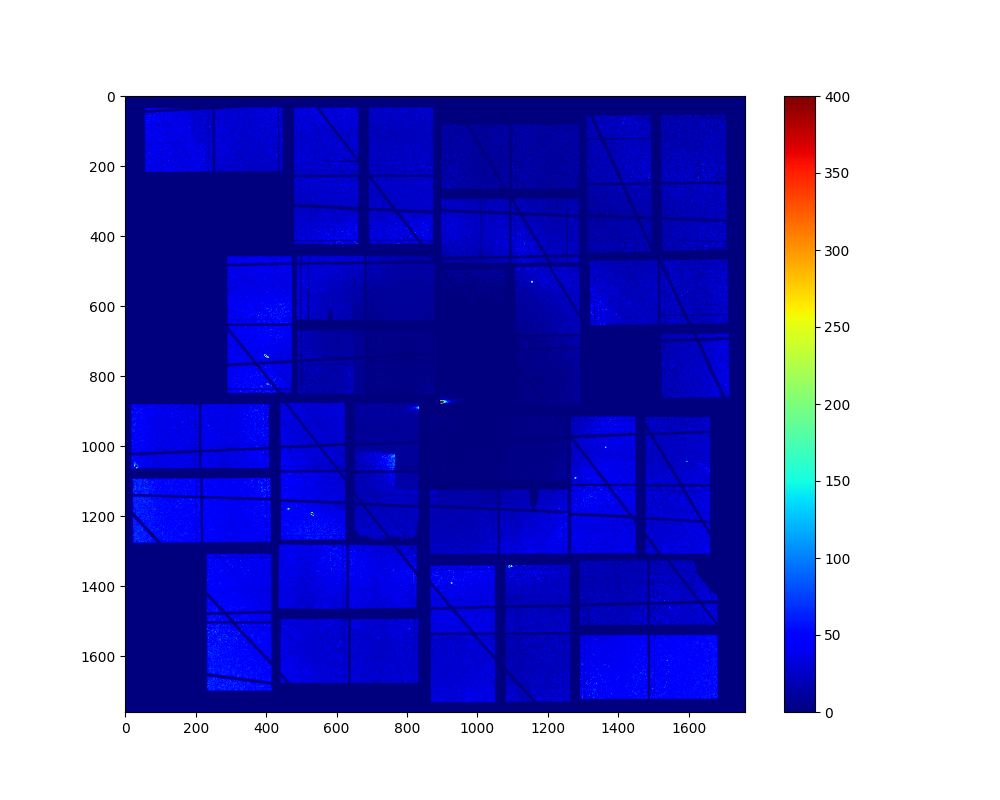

In [686]:
f = h5py.File('/Volumes/harddrive/LCLS/CXI/cxi25410/res/iceFinderCampaign/output_r0146/type1/LCLS_2011_Feb28_r0146_173230_c12c_cspad.h5', 'r')
d = f['data/data'][:]
plt.figure(figsize=[10,8])
plt.imshow(d,cmap='jet', origin = 'lower', aspect='auto')
plt.colorbar();
plt.gca().invert_yaxis()
plt.clim(vmin=0,vmax=400)
plt.show()

In [518]:
q_cm_w = []
for i,n in enumerate(T_w):
    q_cm_w.append(run_list[n]['q_cm'])

In [519]:
q_cm_m = []
for i,n in enumerate(T_m):
    q_cm_m.append(run_list[n]['q_cm'])

In [520]:
q_cm_c = []
for i,n in enumerate(T_c):
    q_cm_c.append(run_list[n]['q_cm'])

In [526]:
import itertools
q_cm_w = np.array(sorted(itertools.chain(*q_cm_w))).T
q_cm_m = np.array(sorted(itertools.chain(*q_cm_m))).T
q_cm_c = np.array(sorted(itertools.chain(*q_cm_c))).T

In [624]:
q_cm_c[np.where(yhist_c == 659)]

array([0.72927411])

In [522]:
T_w = ['r0144','r0145','r0146', 'r0147', 'r0151','r0169','r0170']
T_m = ['r0167', 'r0168', 'r0171', 'r0172', 'r0173']
T_c = ['r0165','r0166']

<IPython.core.display.Javascript object>


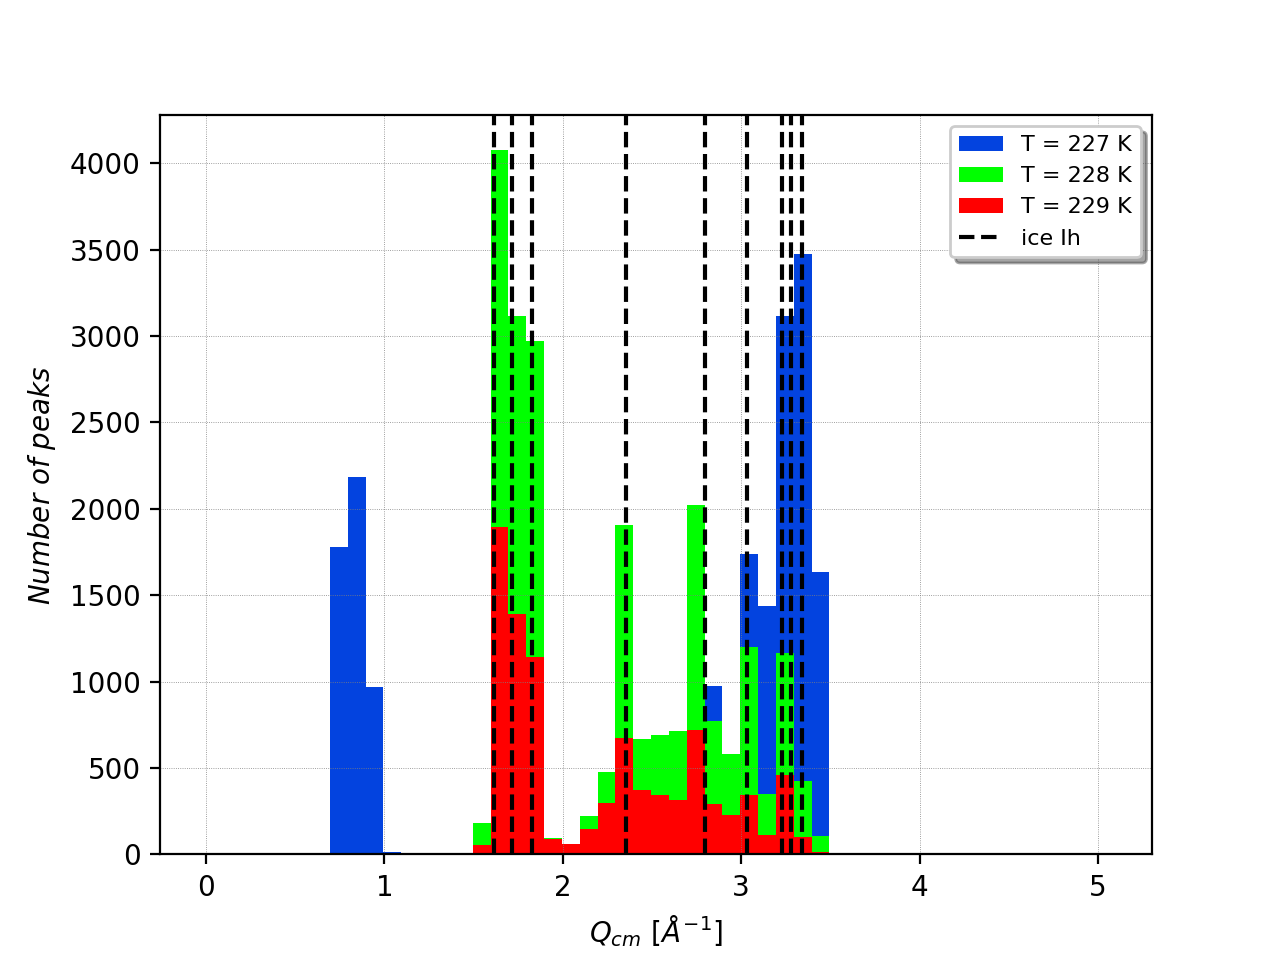

In [729]:
# peak numbers vs q_cm center of mass in q scale
plt.figure()
binwidth = 0.01
binedges = np.arange(0-binwidth/2,5.0+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(q_cm_w, bins=binedges)
yhist_m, bin_edges_m = np.histogram(q_cm_m, bins=binedges)
yhist_c, bin_edges_c = np.histogram(q_cm_c, bins=binedges)
bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])
new_bins, new_q_cm_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_q_cm_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_q_cm_c = downsample(bin_centers3, yhist_c, size=10)

T_227 = plt.bar(new_bins, new_q_cm_c,  color='#0343DF', width=binwidth*10, label= 'T = 227 K')
T_228 = plt.bar(new_bins, new_q_cm_m,  color='#00FF00', width=binwidth*10, label = 'T = 228 K')
T_229 = plt.bar(new_bins, new_q_cm_w,  color='r', width=binwidth*10, label = 'T = 229 K')
xposition = iceIh_peaks()
for xc in xposition[:-1]:
    ice_plot = plt.axvline(x=xc, color='k', linestyle='--')

plt.legend(handles=[T_227, T_228, T_229, ice_plot], labels=['T = 227 K', 'T = 228 K', 'T = 229 K', 'ice Ih'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Q_{cm}\ [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()  


<IPython.core.display.Javascript object>


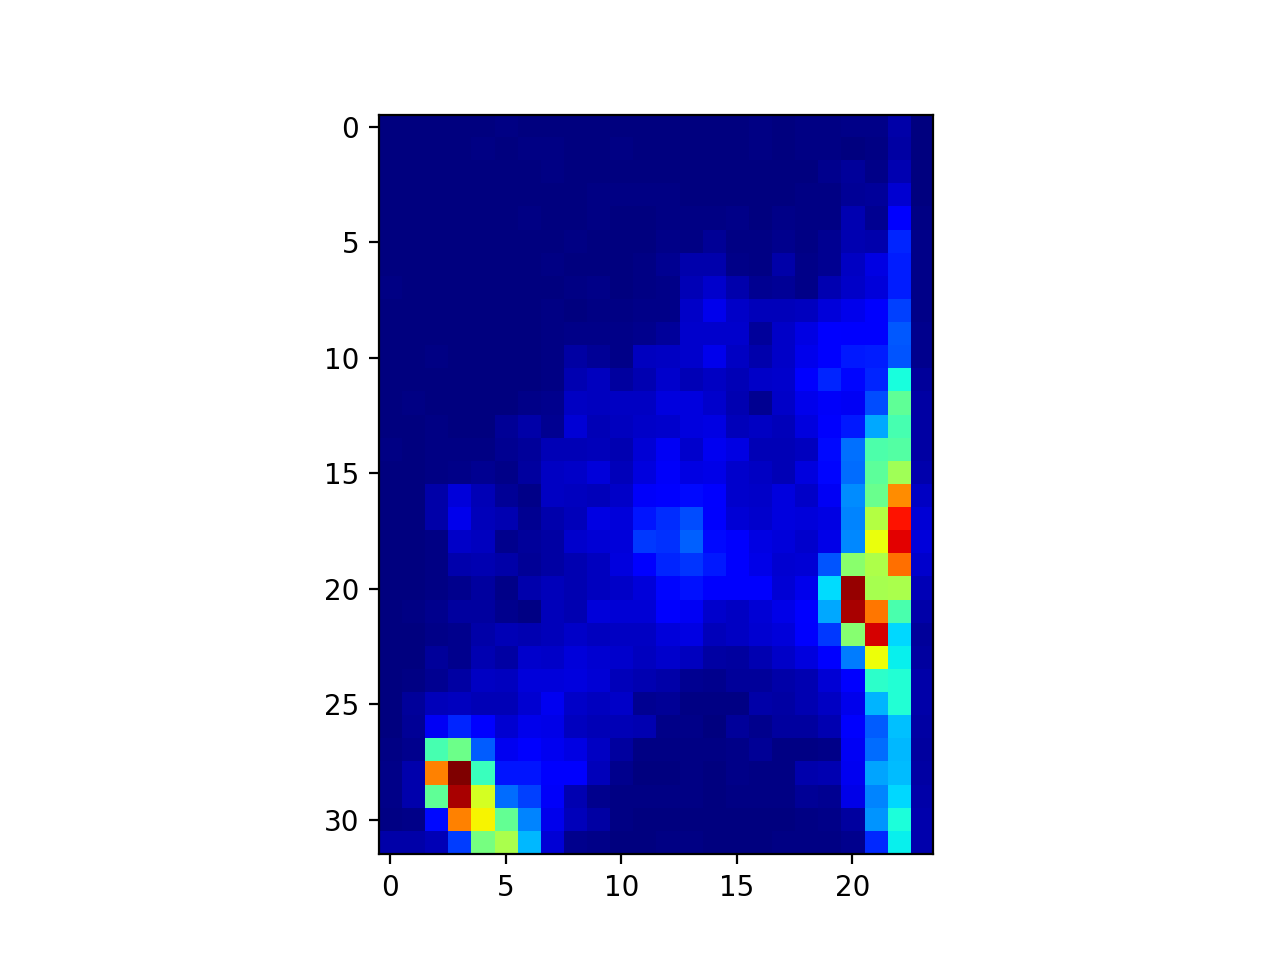

In [41]:
plt.imshow(sphericity_of_peak[265][0],cmap='jet')

In [581]:
def aspect_ratio(run_group):
    sphericity_of_peak = []
    for n, run in enumerate(run_group):
        p = run_list[run]['peaks']
        c_mass = run_list[run]['center_mass']
        for p_i in np.arange(len(p)):
            p_sub = p[p_i] - BG_level
            p_mask = p_sub > photon_threshold
            fill_holes = binary_fill_holes(p_mask)
            contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            for cnt in contours:
                perimeter = cv2.arcLength(cnt, True)
                area = cv2.contourArea(cnt)
                if perimeter != 0:
                    sphericity = 4*np.pi*area/(perimeter**2)
                    #cnt_string = 'Numbers of contours for peak {} : {}, sphericity: {}'
                    #print(cnt_string.format(p_i, len(contours), sphericity))
                    sphericity_of_peak.append(sphericity)
    return sphericity_of_peak

<IPython.core.display.Javascript object>


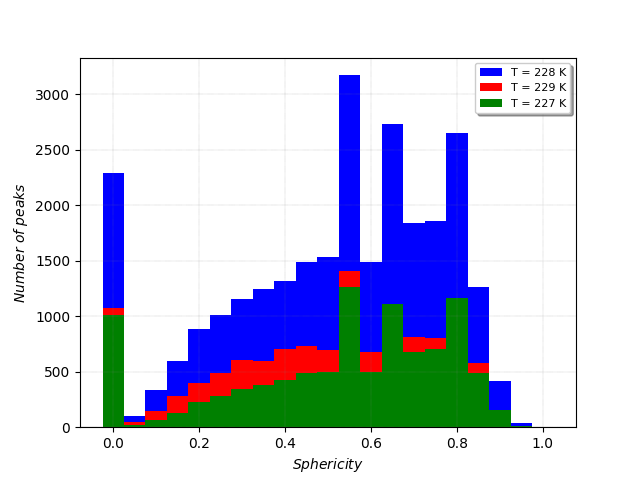

In [589]:
plt.figure()
#binwidth = 1.0/len(S_p)
binwidth = 0.05
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
Sp_w, bin_edges = np.histogram(aspect_ratio(T_w), bins=binedges)
Sp_m, bin_edges = np.histogram(aspect_ratio(T_m), bins=binedges)
Sp_c, bin_edges = np.histogram(aspect_ratio(T_c), bins=binedges)
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])
plt.bar(bin_centers, Sp_m,  color='b', width=binwidth, label = 'T = 228 K')
plt.bar(bin_centers, Sp_w,  color='r', width=binwidth, label = 'T = 229 K')
plt.bar(bin_centers, Sp_c,  color='g', width=binwidth, label = 'T = 227 K')
plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

In [561]:
BG_level = 100
photon_threshold = 2000
sphericity_of_peak = []
for n, run in enumerate(run_list.keys()):
    p = run_list[run]['peaks']
    c_mass = run_list[run]['center_mass']
    for p_i in np.arange(len(p)):
        p_sub = p[p_i] - BG_level
        p_mask = p_sub > photon_threshold
        fill_holes = binary_fill_holes(p_mask)
        contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for cnt in contours:
            perimeter = cv2.arcLength(cnt, True)
            area = cv2.contourArea(cnt)
            if perimeter != 0:
                sphericity = 4*np.pi*area/(perimeter**2)     
                #cnt_string = 'Numbers of contours for peak {} : {}, sphericity: {}'
                #print(cnt_string.format(p_i, len(contours), sphericity))
                sphericity_of_peak.append((p[p_i],len(contours),sphericity))

In [ ]:
# print the center of mass of the peaks inside each shot the coordinates are given in the whole image 1760
for n, run in enumerate(run_list.keys()):
    print(np.shape(run_list[run]['center_mass']))

In [324]:
S_p = np.array([sphericity_of_peak[i][2] for i in range(len(sphericity_of_peak))])

In [15]:
# calculate qx and qy to find distance
wavelength = np.array([run_list[run]['wavelength'] for run in run_list.keys()])
detector_distance = np.array([run_list[run]['detector_distance'] for run in run_list.keys()])
wavelength = np.mean(wavelength)
detector_distance = np.mean(detector_distance)
pixel_size = 109.92*1e-6

center = None
x = np.arange(1760)
y = np.arange(1760)
xx, yy = np.meshgrid(x, y)
if center is None:
    xx = xx.astype(np.float64) - (1760-1)/2
    yy = yy.astype(np.float64) - (1760-1)/2
else:
    xx -= center[1]
    yy -= center[0]
rad = np.sqrt(xx*xx + yy*yy)
 

# calculate qx and qy

qx = 2.*np.pi*2.*np.sin(0.5*np.arctan2(xx*pixel_size, detector_distance))/(wavelength)
qy = 2.*np.pi*2.*np.sin(0.5*np.arctan2(yy*pixel_size, detector_distance))/(wavelength)

In [ ]:
# delta_cx = cx2 (old peak center in whole image 1760) - cx1 (old peak local center peak_region) # new_cx
# delta_cy = cy2 (old peak center in whole image 1760) - cy1 (old peak local center peak_region) # new_cx

In [ ]:
# new cx cut in whole image 1760 = new_cx(ROI) + delta_cx
# new cy cut in whole image 1760 = new_cy(ROI) + delta_cy

In [ ]:
#delta_cx = run_list[run]['peaks'][1] - 

In [ ]:
#delta_cy =

In [446]:
def short_all_dist(run, binwidth=0.01, lower_bound=None, upper_bound=None):
    '''
    returns all distances in each shots for one run and also the minimum 
    distance among all distances for a shot
    
    '''
    hist_tot = np.zeros((811))
    hist_min_tot = np.zeros((811))
    binedges = np.arange(0-binwidth/2,8.1+binwidth/2,binwidth)
    run_path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    run_no = h5py.File(run_path,'r')
    shots = [x for x in run_no['shots'].keys()]
    if (lower_bound is not None) and (upper_bound is not None):
        shots_in_bounds = []
    else:
        shots_in_bounds = None
    for shot_n,each_shot in enumerate(shots):
        n_peaks = run_no['shots'][each_shot]['numberOfPeaks'][()]
        try:
            qcm_x = run_no['shots'][each_shot]['peakCenterOfMassQx'][()]
            qcm_y = run_no['shots'][each_shot]['peakCenterOfMassQy'][()]
        except:
            pass
        q_cm = list(zip(qcm_x,qcm_y))
        d = distance.cdist(q_cm,q_cm)
        all_dist = [d[np.nonzero(d)]]
        distances = np.array(all_dist).flatten()
        if (lower_bound is not None) and (upper_bound is not None):
            if np.any((distances >= lower_bound) & (distances < upper_bound)):
                shots_in_bounds.append(each_shot)
        try:
            min_dist = [np.min(d[np.nonzero(d)])]
        except:
            pass
        min_distances = np.array(min_dist).flatten()
        yhist, bin_edges = np.histogram(distances, bins=binedges)
        minhist, bin_edges = np.histogram(min_distances, bins=binedges)
        yhist = yhist/2
        minhist = minhist/2
        hist_tot += yhist
        hist_min_tot += minhist
    return hist_tot, hist_min_tot, shots_in_bounds

<IPython.core.display.Javascript object>


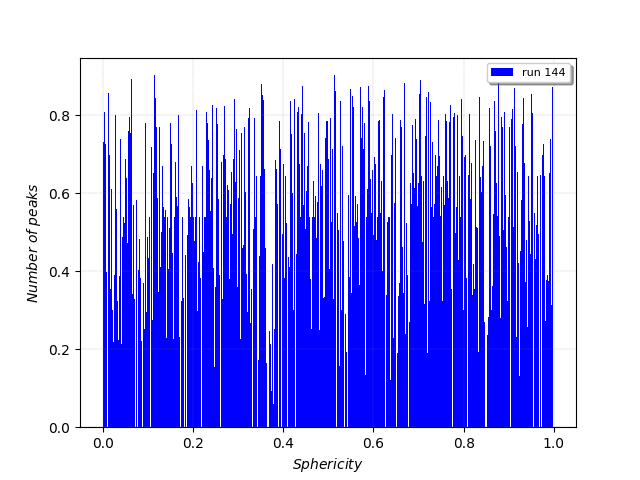

In [430]:
plt.figure()
sp_144 = []
p = run_list['r0144']['peaks']
for p_i in np.arange(len(p)):
    p_sub = p[p_i] - BG_level
    p_mask = p_sub > photon_threshold
    fill_holes = binary_fill_holes(p_mask)
    contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        perimeter = cv2.arcLength(cnt, True)
        area = cv2.contourArea(cnt)
        if perimeter != 0:
            sphericity = 4*np.pi*area/(perimeter**2)     
                #cnt_string = 'Numbers of contours for peak {} : {}, sphericity: {}'
                #print(cnt_string.format(p_i, len(contours), sphericity))
            sp_144.append(sphericity)
binwidth = 1.0/len(sp_144)
binedges = np.arange(0-binwidth/2,1.0+binwidth/2,binwidth)
yhist, bin_edges = np.histogram(sp_144, bins=binedges)
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(sp_144))])
plt.bar(bin_centers, sp_144,  color='b', width=binwidth, label = 'run 144')
plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

<IPython.core.display.Javascript object>


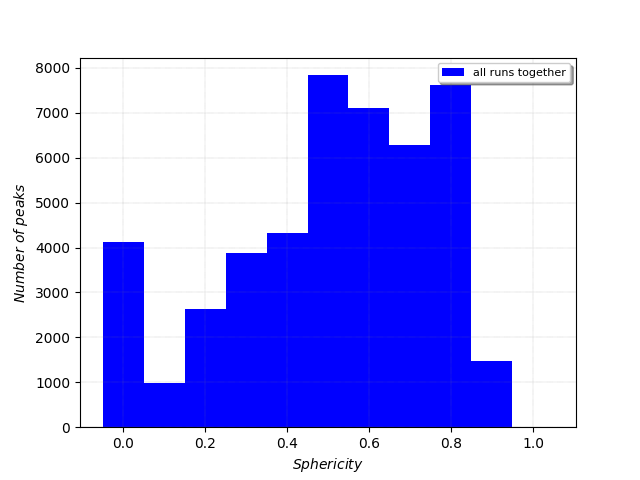

In [409]:
plt.figure()
#binwidth = 1.0/len(S_p)
binwidth = 0.1
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
yhist, bin_edges = np.histogram(S_p, bins=binedges)
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])
plt.bar(bin_centers, yhist,  color='b', width=binwidth, label = 'all runs together')
plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

In [395]:
bin_edges, bin_centers, yhist

(array([-0.05,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,  0.75,
         0.85,  0.95,  1.05]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([4125,  990, 2633, 3879, 4326, 7837, 7108, 6278, 7627, 1473,    0]))

<IPython.core.display.Javascript object>


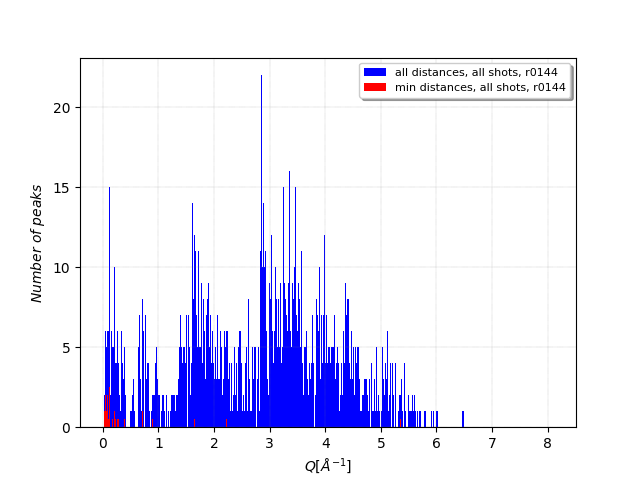

In [447]:
plt.figure()
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(hist_tot))])
plt.bar(bin_centers, short_all_dist('r0144')[0],  color='b', width=binwidth, label = 'all distances, all shots, r0144')
plt.bar(bin_centers, short_all_dist('r0144')[1], color='r', width=binwidth, label = 'min distances, all shots, r0144')
plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Q [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

In [460]:
all_distance = np.zeros((14,811))
min_distance = np.zeros((14,811))
for i,n in enumerate(run_list.keys()):
    all_d, min_d,_ = short_all_dist(n)
    all_distance[i] = all_d
    min_distance[i] = min_d

In [461]:
# warm temperatures runs 144 to 170
all_T_w = np.zeros((7,811))
min_T_w = np.zeros((7,811))
for i,n in enumerate(T_w):
    all_d_T_w, min_d_T_w,_ = short_all_dist(n)
    all_T_w[i] = all_d_T_w
    min_T_w[i] = min_d_T_w

In [462]:
# medium temperatures runs 167 to 173
all_T_m = np.zeros((5,811))
min_T_m = np.zeros((5,811))
for i,n in enumerate(T_m):
    all_d_T_m, min_d_T_m,_ = short_all_dist(n)
    all_T_m[i] = all_d_T_m
    min_T_m[i] = min_d_T_m

In [463]:
# cold temperatures runs 165 to 166
all_T_c = np.zeros((2,811))
min_T_c = np.zeros((2,811))
for i,n in enumerate(T_c):
    all_d_T_c, min_d_T_c,_ = short_all_dist(n)
    all_T_c[i] = all_d_T_c
    min_T_c[i] = min_d_T_c

In [369]:
# binsize = 0.1 or 0.2
def downsample(x, y, size=int(2)):
    assert (len(x) == len(y))
    if (len(x)%size != 0):
        print('WARNING: size of %d in input arrays are not dividable with %d, remainder: %d' % (len(x), size, len(x)%size))
    n = np.int(np.ceil(len(x)/size))
    new_x = np.zeros(n)
    new_y = np.zeros(n)
    for i in range(n):
        new_x[i] = np.average(x[i*size:(i+1)*size])
        new_y[i] = np.sum(y[i*size:(i+1)*size])
    return new_x, new_y


In [381]:
new_bins[16]-binwidth*5, new_bins[18]+binwidth*5, sum_min_dists[16:18], sum_all_dists[16:18]

(1.5950000000000002,
 1.8950000000000002,
 array([214.5, 188.5]),
 array([10153.,  9009.]))

<IPython.core.display.Javascript object>


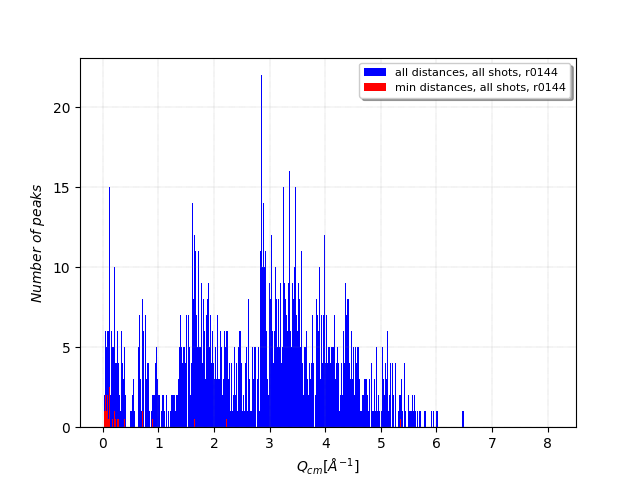

In [599]:
plt.figure()
binwidth = 0.01
hist_tot = np.zeros((811))
hist_min_tot = np.zeros((811))
binedges = np.arange(0-binwidth/2,8.1+binwidth/2,binwidth)
run_path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0144_type1-peaks_with_q.h5'
run_144 = h5py.File(run_path,'r')
shots = [x for x in run_144['shots'].keys()]
for shot_n,each_shot in enumerate(shots):
    n_peaks = run_144['shots'][each_shot]['numberOfPeaks'][()]
    try:
        qcm_x = run_144['shots'][each_shot]['peakCenterOfMassQx'][()]
        qcm_y = run_144['shots'][each_shot]['peakCenterOfMassQy'][()]
    except:
        pass   
    q_cm = list(zip(qcm_x,qcm_y))
    d = distance.cdist(q_cm,q_cm)
    all_dist = [d[np.nonzero(d)]]
    distances = np.array(all_dist).flatten()
    try:
        min_dist = [np.min(d[np.nonzero(d)])]
    except:
        pass
    min_distances = np.array(min_dist).flatten()
    yhist, bin_edges = np.histogram(distances, bins=binedges)
    minhist, bin_edges = np.histogram(min_distances, bins=binedges)
    yhist = yhist/2
    minhist = minhist/2
    hist_tot += yhist
    hist_min_tot += minhist
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(hist_tot))])
plt.bar(bin_centers, hist_tot,  color='b', width=binwidth, label = 'all distances, all shots, r0144')
plt.bar(bin_centers, hist_min_tot, color='r', width=binwidth, label = 'min distances, all shots, r0144')
plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Q_{cm} [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

<IPython.core.display.Javascript object>


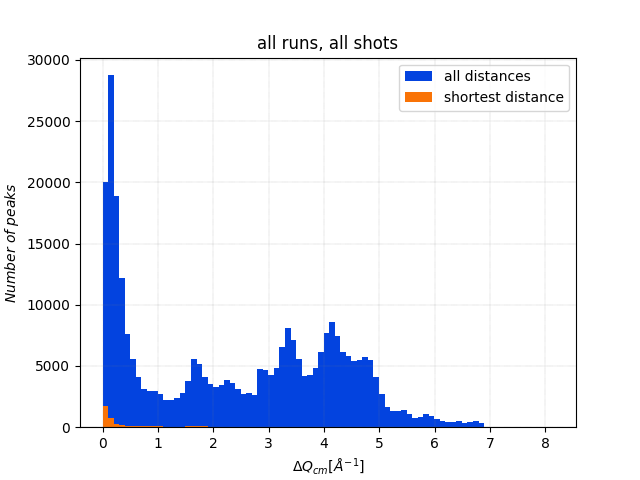

In [600]:
# peak numbers vs q_cm
plt.figure()
binwidth = 0.01
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(hist_tot))])
for i,run in enumerate(run_list.keys()):
    new_bins, new_all_dists = downsample(bin_centers, all_distance[i], size=10)
    new_bins, new_min_dists = downsample(bin_centers, min_distance[i], size=10)
    if i == 0:
        sum_all_dists = new_all_dists
        sum_min_dists = new_min_dists
    else:
        sum_all_dists += new_all_dists
        sum_min_dists += new_min_dists
    #plt.bar(bin_centers, all_distance[i],  color='#0343DF', width=binwidth)
    #plt.bar(bin_centers, min_distance[i], color='#F97306', width=binwidth)
plt.bar(new_bins, sum_all_dists,  color='#0343DF', width=binwidth*10)
plt.bar(new_bins, sum_min_dists, color='#F97306', width=binwidth*10)
plt.legend(['all distances','shortest distance'])
plt.title('all runs, all shots', loc='center')
plt.xlabel('$\Delta Q_{cm} [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()  


<IPython.core.display.Javascript object>


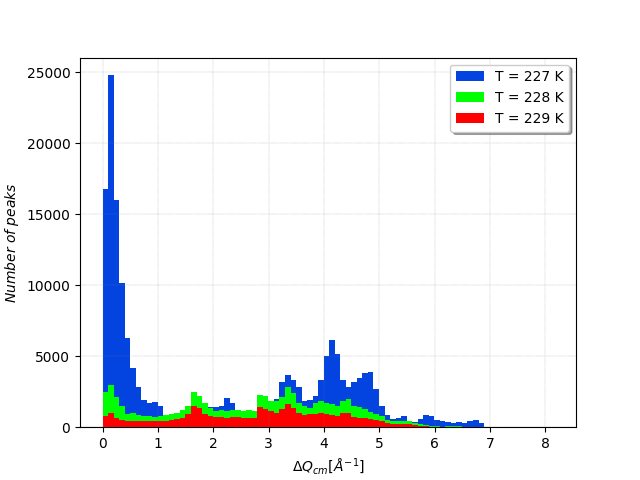

In [507]:
# peak numbers vs q_cm for the warm temperatures
plt.figure()
binwidth = 0.01
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(hist_tot))])
for i,run in enumerate(T_w):
    new_bins, new_T_w_dists = downsample(bin_centers, all_T_w[i], size=10)
    new_bins, new_min_T_w = downsample(bin_centers, min_T_w[i], size=10)
    if i == 0:
        sum_T_w_dists = new_T_w_dists
        sum_min_T_w = new_min_T_w
    else:
        sum_T_w_dists += new_T_w_dists
        sum_min_T_w += new_min_T_w
        
for i,run in enumerate(T_m):
    new_bins, new_T_m_dists = downsample(bin_centers, all_T_m[i], size=10)
    new_bins, new_min_T_m = downsample(bin_centers, min_T_m[i], size=10)
    if i == 0:
        sum_T_m_dists = new_T_m_dists
        sum_min_T_m = new_min_T_m
    else:
        sum_T_m_dists += new_T_m_dists
        sum_min_T_m += new_min_T_m
        
for i,run in enumerate(T_c):
    new_bins, new_T_c_dists = downsample(bin_centers, all_T_c[i], size=10)
    new_bins, new_min_T_c = downsample(bin_centers, min_T_c[i], size=10)
    if i == 0:
        sum_T_c_dists = new_T_c_dists
        sum_min_T_c = new_min_T_c
    else:
        sum_T_c_dists += new_T_c_dists
        sum_min_T_c += new_min_T_c
        

    #plt.bar(bin_centers, all_distance[i],  color='#0343DF', width=binwidth)
    #plt.bar(bin_centers, min_distance[i], color='#F97306', width=binwidth)
plt.bar(new_bins, sum_T_c_dists, color='#0343DF', width=binwidth*10, label = 'T = 227 K')
plt.bar(new_bins, sum_T_m_dists, color='#00FF00', width=binwidth*10, label = 'T = 228 K')
plt.bar(new_bins, sum_T_w_dists,  color='r', width=binwidth*10, label = 'T = 229 K')

plt.legend(loc='upper right', prop={'size': 10}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
#plt.title('all runs, all shots', loc='center')
plt.xlabel('$\Delta Q_{cm} [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()  


<IPython.core.display.Javascript object>


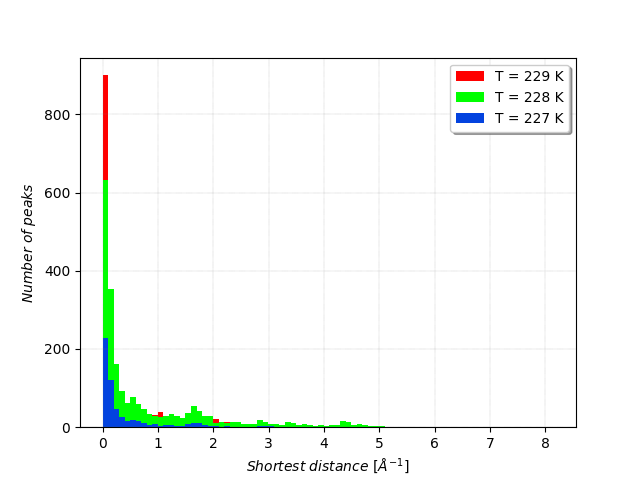

In [513]:
plt.figure()
plt.bar(new_bins, sum_min_T_c,  color='r', width=binwidth*10, label = 'T = 229 K')
plt.bar(new_bins, sum_min_T_m, color='#00FF00', width=binwidth*10, label = 'T = 228 K')
plt.bar(new_bins, sum_min_T_w, color='#0343DF', width=binwidth*10, label = 'T = 227 K')

plt.legend(loc='upper right', prop={'size': 10}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
#plt.title('all runs, all shots', loc='center')
plt.xlabel('$Shortest\ distance\ [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()  


In [196]:
minin =[]
for i in nozero_d:
    try:
        minin.append(np.min(i))
    except:
        pass

In [197]:
np.shape(nozero_d), np.shape(minin)

((479,), (478,))

In [162]:
for shot_n,each_shot in enumerate(shots):
    try:
        print(run_144['shots'][each_shot]['peakCenterOfMassQx'][()])
    except:
        pass

[ 1.45629733 -0.1975671  -1.54001448 -1.799212   -2.37943865  1.28122195
 -1.08277001  0.04094767 -0.42378581]
[-0.35965622 -2.22330629 -1.2591992   1.16633465  2.6376728  -1.75486017
 -0.30711799  2.15479089  2.05066242  2.10019886  2.3106313  -1.87419105
  0.73713051]
[ 0.41292026 -0.10618865 -1.50115661  1.33498372  1.38821247 -1.51179025
 -1.45343903  1.40340588  1.44005384  1.39626701 -0.00526704]
[ 2.22978554 -1.27461792  2.21800844  1.58720518 -1.32917391  1.55847075
  1.50742493  0.60612872 -1.5016185   1.33376477 -2.18037997]
[ 0.91568871 -2.46537268  0.56877499  0.35775186 -1.11301215  1.04459299
  0.42028768 -0.67830438 -0.88099291  2.27455133]
[ 2.08935192  0.67379145  2.70862735 -1.60970736 -1.42922021  1.54505658
 -1.36465854  0.26546458]
[ 2.50037246 -1.23923896  0.61628592  0.71752769 -1.63157337  1.89847588
  0.06870383  2.07672737  1.96208852 -0.92646041 -1.35524998]
[ 2.41041251  2.22490477  1.81044051  0.17284617 -1.55247478  1.86776372
 -1.46230977 -1.23910702 -1.3

In [155]:
x = run_144['shots']['LCLS_2011_Feb28_r0144_163006_2feb_cspad']['peakCenterOfMassQx'][()]

In [156]:
y = run_144['shots']['LCLS_2011_Feb28_r0144_163006_2feb_cspad']['peakCenterOfMassQy'][()]

In [157]:
list(zip(x,y))

[(0.4129202616777565, -1.8791951968943919),
 (-0.1061886510865614, -1.7555068730843517),
 (-1.5011566055745893, -1.1997693692428788),
 (1.3349837223396062, -1.0429577522031999),
 (1.388212469801472, -1.0723652294081458),
 (-1.5117902525081894, -0.603837080807235),
 (-1.4534390318401775, 0.7423097255451431),
 (1.4034058846930053, 0.8601034558833442),
 (1.4400538365956388, 0.9560856872426438),
 (1.3962670055270654, 1.051083661773669),
 (-0.005267040374824249, 1.6958082694231058)]

In [613]:
window1 = []
for i,n in enumerate(T_w):
    _, _, w = short_all_dist(n, lower_bound = 1.6 , upper_bound = 1.8 )
    window1.append(w)

In [616]:
window2 = []
for i,n in enumerate(T_m):
    _, _, w = short_all_dist(n, lower_bound = 1.6 , upper_bound = 1.8 )
    window2.append(w)

In [617]:
window3 = []
for i,n in enumerate(T_c):
    _, _, w = short_all_dist(n, lower_bound = 1.6 , upper_bound = 1.8 )
    window3.append(w)

In [ ]:
# function in swissfel
#iceIh_peaks()
#SwissFEL-Bernina/src/